In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt

## Import Mobility Data

In [2]:
# keep FIPS as string to preserve leading zeroes
# https://www.google.com/covid19/mobility/

In [3]:
mob = pd.read_csv(r"/Users/philip.ballentine/Documents/hia_covid_repo/hia_covid_data_assets/hia_covid_inputs/2020_US_Region_Mobility_Report.csv", dtype={'census_fips_code': 'str'} )

In [4]:
mob.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'census_fips_code', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

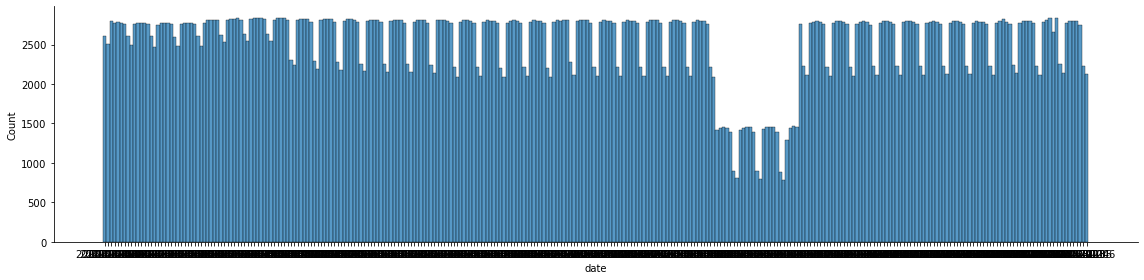

In [5]:
sns.displot(mob.date, height=4, aspect=4, )
#plt.xticks(ticks_locations, labels, rotation=90)

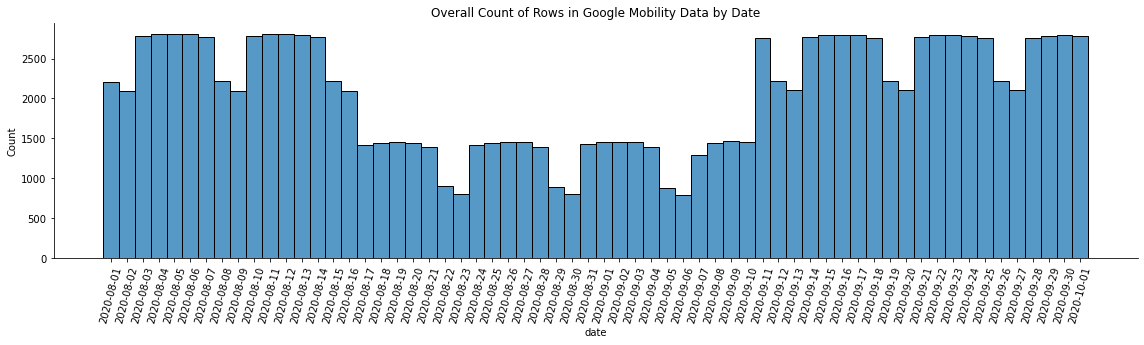

In [6]:
mob_sub = mob[(mob.date >= '2020-08-01') & (mob.date <= '2020-10-01')]
g = sns.displot(mob_sub.date, height=4, aspect=4, )
plt.xticks(rotation=75)
plt.title("Overall Count of Rows in Google Mobility Data by Date")
g

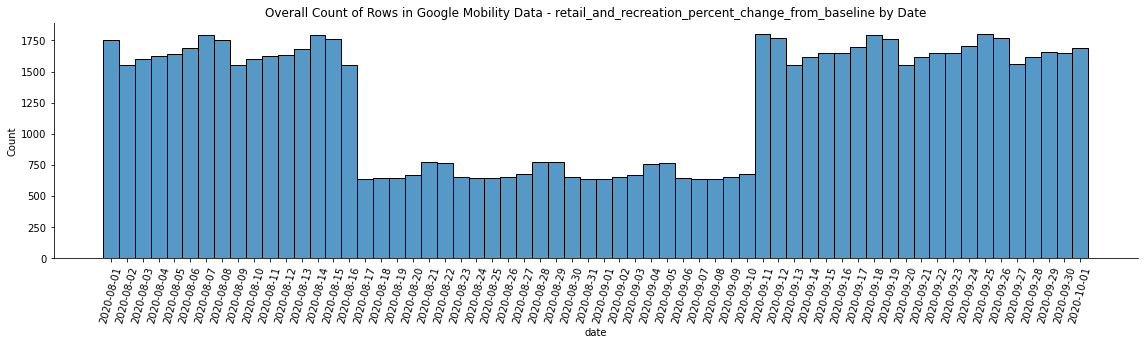

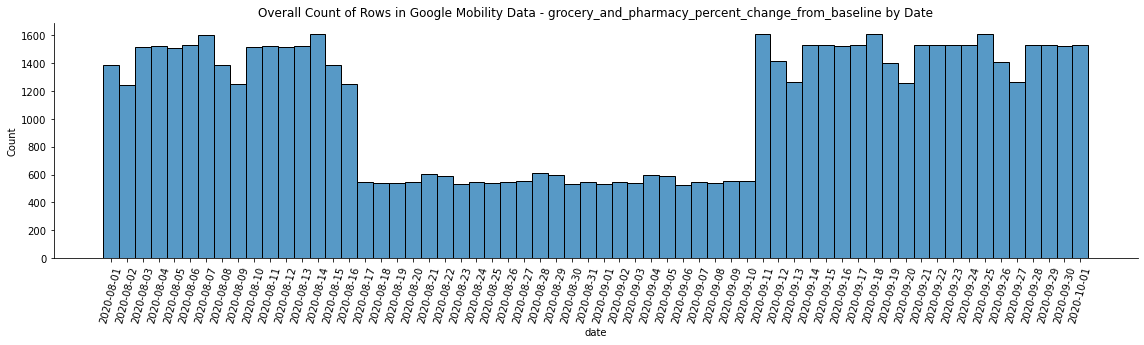

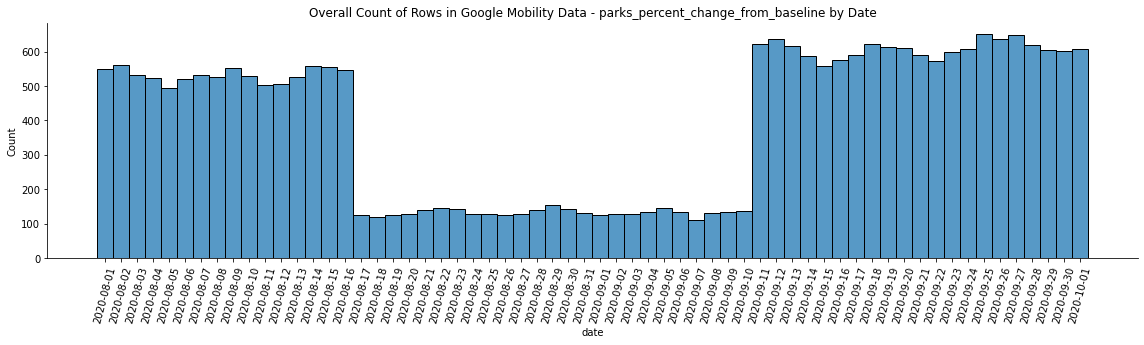

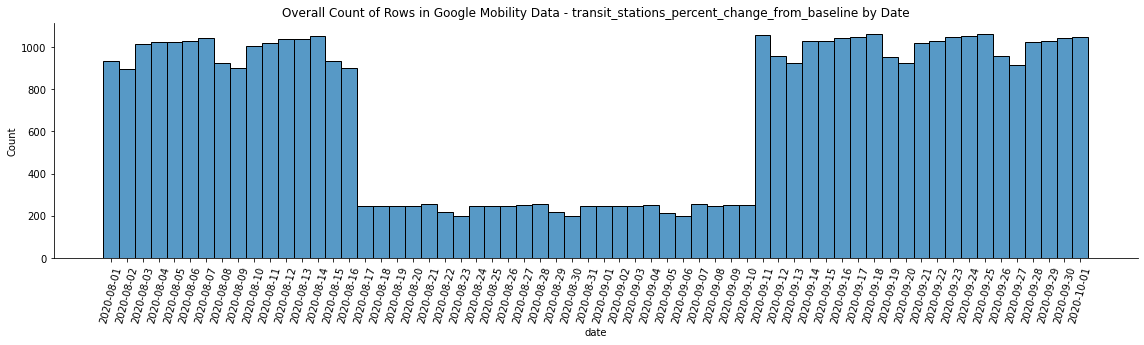

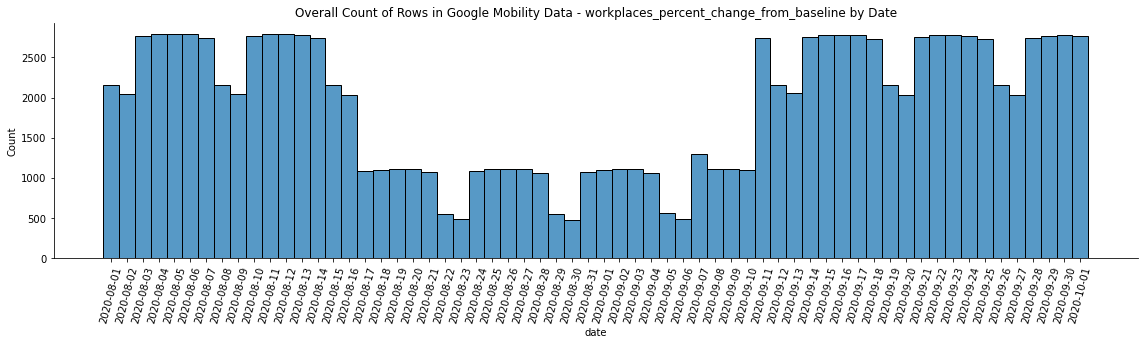

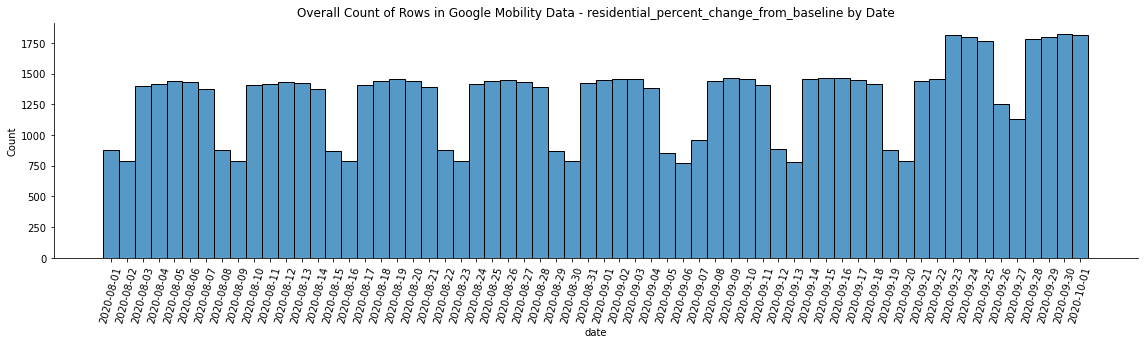

In [7]:
list_col = [
'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'
    ]

for i in list_col:
    mob_sub_notna = mob_sub[mob_sub['{i}'.format(i=i)].isna() == False]
    g = sns.displot(mob_sub_notna.date, height=4, aspect=4, )
    plt.xticks(rotation=75)
    plt.title("Overall Count of Rows in Google Mobility Data - {i} by Date".format(i=i))
    g.savefig("Overall Count of Rows in Google Mobility Data - {i} by Date.jpg".format(i=i))
    

In [8]:
list_col = [
'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       #'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline' #, 
       #'residential_percent_change_from_baseline'
    ]

counties_present_dict = dict()
for i in list_col:
    low_period = mob[(mob.date >= '2020-08-30') & (mob.date <= '2020-09-06')]
    low_period = low_period[low_period['{i}'.format(i=i)].isna() == False]
    counties_present = low_period.census_fips_code.unique()
    counties_present_dict[i] = set(counties_present)

In [9]:
overlap = set(mob.census_fips_code.unique())
all_set = set()

for i in counties_present_dict.values():
    not_there = overlap - i
    overlap_notthere = overlap.intersection(not_there)
    all_set = all_set.union(not_there)

In [10]:
len(set(mob.census_fips_code.unique()))
# All counties 

2836

In [11]:
len(overlap_notthere)
# Missing all three (transit, grocery, workplace) throughout period

1774

In [12]:
len(all_set)
# Missing at least one (transit, grocery, workplace) throughout period

2630

In [13]:
mob['date'] = mob['date'].astype('datetime64')

In [14]:
mob_renam_col = [i.replace('percent_change_from_baseline', 'PCT_CFB') for i in mob.columns]

In [15]:
mob.columns = mob_renam_col

In [16]:
mob_renam_col

['country_region_code',
 'country_region',
 'sub_region_1',
 'sub_region_2',
 'metro_area',
 'iso_3166_2_code',
 'census_fips_code',
 'date',
 'retail_and_recreation_PCT_CFB',
 'grocery_and_pharmacy_PCT_CFB',
 'parks_PCT_CFB',
 'transit_stations_PCT_CFB',
 'workplaces_PCT_CFB',
 'residential_PCT_CFB']

In [17]:
mob.dtypes

country_region_code                      object
country_region                           object
sub_region_1                             object
sub_region_2                             object
metro_area                              float64
iso_3166_2_code                          object
census_fips_code                         object
date                             datetime64[ns]
retail_and_recreation_PCT_CFB           float64
grocery_and_pharmacy_PCT_CFB            float64
parks_PCT_CFB                           float64
transit_stations_PCT_CFB                float64
workplaces_PCT_CFB                      float64
residential_PCT_CFB                     float64
dtype: object

In [18]:
mob.sort_values(by="date", inplace=True)

In [19]:
mob.head(5)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_PCT_CFB,grocery_and_pharmacy_PCT_CFB,parks_PCT_CFB,transit_stations_PCT_CFB,workplaces_PCT_CFB,residential_PCT_CFB
0,US,United States,NaN,NaN,NaN,NaN,NaN,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
560080,US,United States,South Carolina,Horry County,NaN,NaN,45051,2020-02-15,24.0,12.0,44.0,9.0,3.0,0.0
560376,US,United States,South Carolina,Jasper County,NaN,NaN,45053,2020-02-15,9.0,0.0,27.0,-3.0,-7.0,NaN
560660,US,United States,South Carolina,Kershaw County,NaN,NaN,45055,2020-02-15,1.0,6.0,NaN,-5.0,1.0,-1.0
67899,US,United States,Colorado,Las Animas County,NaN,NaN,08071,2020-02-15,3.0,6.0,NaN,NaN,7.0,NaN


## Compute Rolling Average of Mobility Data

In [20]:
list_all_locations = list(mob.census_fips_code.unique())
list_frames = []
for i in list_all_locations:
    frame = mob[mob.census_fips_code == i]
    frame['retail_and_recreation_PCT_CFB_RollingAvg'] = frame.rolling(7, min_periods=7, center=False, on="date")['retail_and_recreation_PCT_CFB'].mean()
    frame['grocery_and_pharmacy_PCT_CFB_RollingAvg'] = frame.rolling(7, min_periods=7, center=False, on="date")['grocery_and_pharmacy_PCT_CFB'].mean()
    frame['parks_PCT_CFB_RollingAvg'] = frame.rolling(7, min_periods=7, center=False, on="date")['parks_PCT_CFB'].mean()
    frame['transit_stations_PCT_CFB_RollingAvg'] = frame.rolling(7, min_periods=7, center=False, on="date")['transit_stations_PCT_CFB'].mean()
    frame['workplaces_PCT_CFB_RollingAvg'] = frame.rolling(7, min_periods=7, center=False, on="date")['workplaces_PCT_CFB'].mean()
    frame['residential_PCT_CFB_RollingAvg'] = frame.rolling(7, min_periods=7, center=False, on="date")['residential_PCT_CFB'].mean()
    list_frames.append(frame)

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [21]:
recombine = pd.concat(list_frames)

In [22]:
mobility_final = recombine

In [23]:
mobility_final['Date'] = mobility_final['date']

mobility_final.drop(columns=['date'], inplace=True)

In [24]:
mobility_final['County_FIPS'] = mobility_final['census_fips_code']
mobility_final.drop(columns=['census_fips_code'], inplace=True)

In [25]:
mobility_final[(mobility_final.County_FIPS == "12009") & (mobility_final.Date > '2020-10-01')].head(-18)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,retail_and_recreation_PCT_CFB,grocery_and_pharmacy_PCT_CFB,parks_PCT_CFB,transit_stations_PCT_CFB,workplaces_PCT_CFB,residential_PCT_CFB,retail_and_recreation_PCT_CFB_RollingAvg,grocery_and_pharmacy_PCT_CFB_RollingAvg,parks_PCT_CFB_RollingAvg,transit_stations_PCT_CFB_RollingAvg,workplaces_PCT_CFB_RollingAvg,residential_PCT_CFB_RollingAvg,Date,County_FIPS
79257,US,United States,Florida,Brevard County,NaN,NaN,-18.0,-11.0,-6.0,-16.0,-26.0,6.0,-19.571429,-12.285714,-13.428571,-20.142857,-24.142857,6.142857,2020-10-02,12009
79258,US,United States,Florida,Brevard County,NaN,NaN,-23.0,-15.0,-34.0,-32.0,-17.0,5.0,-20.000000,-12.857143,-18.857143,-20.285714,-24.428571,6.285714,2020-10-03,12009
79259,US,United States,Florida,Brevard County,NaN,NaN,-19.0,-13.0,-32.0,-24.0,-19.0,4.0,-20.142857,-13.000000,-22.000000,-19.714286,-24.571429,6.285714,2020-10-04,12009
79260,US,United States,Florida,Brevard County,NaN,NaN,-22.0,-14.0,-27.0,-14.0,-28.0,7.0,-19.714286,-12.428571,-20.714286,-19.000000,-24.571429,6.142857,2020-10-05,12009
79261,US,United States,Florida,Brevard County,NaN,NaN,-19.0,-12.0,-10.0,-9.0,-28.0,7.0,-19.571429,-12.428571,-18.428571,-18.000000,-24.714286,6.142857,2020-10-06,12009
79262,US,United States,Florida,Brevard County,NaN,NaN,-19.0,-11.0,-15.0,-15.0,-27.0,7.0,-19.714286,-12.571429,-18.571429,-17.571429,-24.571429,6.142857,2020-10-07,12009
79263,US,United States,Florida,Brevard County,NaN,NaN,-20.0,-13.0,-3.0,-8.0,-27.0,7.0,-20.000000,-12.714286,-18.142857,-16.857143,-24.571429,6.142857,2020-10-08,12009
79264,US,United States,Florida,Brevard County,NaN,NaN,-19.0,-12.0,-14.0,-16.0,-26.0,7.0,-20.142857,-12.857143,-19.285714,-16.857143,-24.571429,6.285714,2020-10-09,12009
79265,US,United States,Florida,Brevard County,NaN,NaN,-21.0,-14.0,-19.0,-30.0,-16.0,5.0,-19.857143,-12.714286,-17.142857,-16.571429,-24.428571,6.285714,2020-10-10,12009
79266,US,United States,Florida,Brevard County,NaN,NaN,-20.0,-15.0,-18.0,-23.0,-18.0,4.0,-20.000000,-13.000000,-15.142857,-16.428571,-24.285714,6.285714,2020-10-11,12009


## Import County-Level Dataset

In [26]:
counties = pd.read_csv(r"/Users/philip.ballentine/Documents/hia_covid_repo/hia_covid_data_assets/counties_dataset_full.csv",dtype={'County_FIPS':'str'})

In [27]:
counties.dtypes

Unnamed: 0                 int64
County_FIPS               object
StateCD                   object
Name                      object
HS_DIPLOMA_ONLY_2018     float64
SOME_COLLEGE_2018        float64
BACHELORS_PLUS_2018      float64
Poverty_PCT_2018         float64
UrbanCD                    int64
Median_Income_2018       float64
Population_ACS           float64
Population_Black_ACS     float64
Population_Hisp_ACS      float64
Population_Native_ACS    float64
PCT_Black_ACS            float64
PCT_Hisp_ACS             float64
PCT_Native_ACS           float64
UrbanCD_Description       object
Metro                     object
dtype: object

In [28]:
#mobility_counties = mobility_final.merge(counties, on = "census_fips_code", how="left")

## Bring in the COVID Data to be Joined In 

In [29]:
covid = pd.read_csv(r"/Users/philip.ballentine/Documents/hia_covid_repo/hia_covid_data_assets/covid_dataset_full.csv",dtype={'County_FIPS':'str'})

In [30]:
covid.Date = covid.Date.astype("datetime64")

In [31]:
covid.shape[0]

1058148

In [32]:
mobility_final.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'retail_and_recreation_PCT_CFB',
       'grocery_and_pharmacy_PCT_CFB', 'parks_PCT_CFB',
       'transit_stations_PCT_CFB', 'workplaces_PCT_CFB', 'residential_PCT_CFB',
       'retail_and_recreation_PCT_CFB_RollingAvg',
       'grocery_and_pharmacy_PCT_CFB_RollingAvg', 'parks_PCT_CFB_RollingAvg',
       'transit_stations_PCT_CFB_RollingAvg', 'workplaces_PCT_CFB_RollingAvg',
       'residential_PCT_CFB_RollingAvg', 'Date', 'County_FIPS'],
      dtype='object')

In [33]:
covid_mobility = covid.merge(mobility_final, on =['Date','County_FIPS'], how="left")

In [34]:
# Join in the Urban Data

In [35]:
mobility_covid_urban = covid_mobility.merge(counties, on=['County_FIPS'])

In [36]:
# Can't deal with the + signs, so remove these 

large_columns = list(mobility_covid_urban.columns)
large_columns = [x.replace('+','') for x in large_columns]
mobility_covid_urban.columns = large_columns

In [37]:
list(mobility_covid_urban.columns)

['Unnamed: 0_x',
 'Date',
 'Admin2',
 'State',
 'Confirmed',
 'Deaths',
 'Country/Region',
 'Deaths_Previous',
 'Confirmed_Previous',
 'Deaths_New',
 'Deaths_New_7',
 'Deaths_New_14',
 'Deaths_New_21',
 'Deaths_New_28',
 'Confirmed_New',
 'locationcol',
 'Confirmed_New_RollingAvg',
 'Deaths_New_RollingAvg',
 'Deaths_New_7_RollingAvg',
 'Deaths_New_14_RollingAvg',
 'Deaths_New_21_RollingAvg',
 'Deaths_New_28_RollingAvg',
 'County_FIPS',
 'State Code',
 'Region',
 'Division',
 'country_region_code',
 'country_region',
 'sub_region_1',
 'sub_region_2',
 'metro_area',
 'iso_3166_2_code',
 'retail_and_recreation_PCT_CFB',
 'grocery_and_pharmacy_PCT_CFB',
 'parks_PCT_CFB',
 'transit_stations_PCT_CFB',
 'workplaces_PCT_CFB',
 'residential_PCT_CFB',
 'retail_and_recreation_PCT_CFB_RollingAvg',
 'grocery_and_pharmacy_PCT_CFB_RollingAvg',
 'parks_PCT_CFB_RollingAvg',
 'transit_stations_PCT_CFB_RollingAvg',
 'workplaces_PCT_CFB_RollingAvg',
 'residential_PCT_CFB_RollingAvg',
 'Unnamed: 0_y',
 'St

In [38]:
columns = [ 'Date',
 'County_FIPS',
 'State Code',
 'Name',
 'retail_and_recreation_PCT_CFB',
 'grocery_and_pharmacy_PCT_CFB',
 'parks_PCT_CFB',
 'transit_stations_PCT_CFB',
 'workplaces_PCT_CFB',
 'residential_PCT_CFB',
 'retail_and_recreation_PCT_CFB_RollingAvg',
 'grocery_and_pharmacy_PCT_CFB_RollingAvg',
 'parks_PCT_CFB_RollingAvg',
 'transit_stations_PCT_CFB_RollingAvg',
 'workplaces_PCT_CFB_RollingAvg',
 'residential_PCT_CFB_RollingAvg',
 'HS_DIPLOMA_ONLY_2018',
 'SOME_COLLEGE_2018',
 'BACHELORS_PLUS_2018',
 'Poverty_PCT_2018',
 'UrbanCD',
 'Median_Income_2018',
 'Population_ACS',
 'Population_Black_ACS',
 'Population_Hisp_ACS',
 'Population_Native_ACS',
 'PCT_Black_ACS',
 'PCT_Hisp_ACS',
 'PCT_Native_ACS',
 'UrbanCD_Description',
 'Metro',
 'State',
 'Confirmed',
 'Deaths',
 'Country/Region',
 'Deaths_Previous',
 'Confirmed_Previous',
 'Deaths_New',
 'Deaths_New_7',
 'Deaths_New_14',
 'Deaths_New_21',
 'Deaths_New_28',
 'Confirmed_New',
 'locationcol',
 'Confirmed_New_RollingAvg',
 'Deaths_New_RollingAvg',
 'Deaths_New_7_RollingAvg',
 'Deaths_New_14_RollingAvg',
 'Deaths_New_21_RollingAvg',
 'Deaths_New_28_RollingAvg',
 ]

In [39]:
combined_dataset_sub = mobility_covid_urban[columns]

In [40]:
combined_dataset_sub

,Date,County_FIPS,State Code,Name,retail_and_recreation_PCT_CFB,grocery_and_pharmacy_PCT_CFB,parks_PCT_CFB,transit_stations_PCT_CFB,workplaces_PCT_CFB,residential_PCT_CFB,...,Deaths_New_21,Deaths_New_28,Confirmed_New,locationcol,Confirmed_New_RollingAvg,Deaths_New_RollingAvg,Deaths_New_7_RollingAvg,Deaths_New_14_RollingAvg,Deaths_New_21_RollingAvg,Deaths_New_28_RollingAvg
0,2020-01-22,01001,AL,Autauga County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,Autauga|Alabama,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-23,01001,AL,Autauga County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,Autauga|Alabama,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-24,01001,AL,Autauga County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,Autauga|Alabama,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-25,01001,AL,Autauga County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,Autauga|Alabama,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-26,01001,AL,Autauga County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,Autauga|Alabama,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010985,2020-12-05,56045,WY,Weston County,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,Weston|Wyoming,3.285714,0.142857,NaN,NaN,NaN,NaN
1010986,2020-12-06,56045,WY,Weston County,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,Weston|Wyoming,3.428571,0.142857,NaN,NaN,NaN,NaN
1010987,2020-12-07,56045,WY,Weston County,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,Weston|Wyoming,3.571429,0.142857,NaN,NaN,NaN,NaN
1010988,2020-12-08,56045,WY,Weston County,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,Weston|Wyoming,2.285714,0.000000,NaN,NaN,NaN,NaN


In [41]:
#check to see matching
combined_dataset_sub[['State','State Code']].sample(frac=.00004)


,State,State Code
730411,Pennsylvania,PA
838616,Texas,TX
958238,Washington,WA
122960,Florida,FL
792638,Tennessee,TN
560620,Nebraska,NE
386700,Maryland,MD
628422,North Carolina,NC
592387,New York,NY
47459,Arkansas,AR


In [42]:
def create_percapita_measures(dataframe):
    list_col = list(dataframe.columns)
    for i in list(dataframe.columns):
        if "death" in i.lower() or "confirmed" in i.lower() and "previous" not in i.lower() :
            try:
                new_col_name = i+'_PER_100K'
                dataframe[new_col_name] = dataframe[i]/(dataframe['Population_ACS']/100000)
            except:
                print("error occurred for {i}".format(i=i)) 

In [43]:
create_percapita_measures(combined_dataset_sub)

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [44]:
list(combined_dataset_sub.columns)

['Date',
 'County_FIPS',
 'State Code',
 'Name',
 'retail_and_recreation_PCT_CFB',
 'grocery_and_pharmacy_PCT_CFB',
 'parks_PCT_CFB',
 'transit_stations_PCT_CFB',
 'workplaces_PCT_CFB',
 'residential_PCT_CFB',
 'retail_and_recreation_PCT_CFB_RollingAvg',
 'grocery_and_pharmacy_PCT_CFB_RollingAvg',
 'parks_PCT_CFB_RollingAvg',
 'transit_stations_PCT_CFB_RollingAvg',
 'workplaces_PCT_CFB_RollingAvg',
 'residential_PCT_CFB_RollingAvg',
 'HS_DIPLOMA_ONLY_2018',
 'SOME_COLLEGE_2018',
 'BACHELORS_PLUS_2018',
 'Poverty_PCT_2018',
 'UrbanCD',
 'Median_Income_2018',
 'Population_ACS',
 'Population_Black_ACS',
 'Population_Hisp_ACS',
 'Population_Native_ACS',
 'PCT_Black_ACS',
 'PCT_Hisp_ACS',
 'PCT_Native_ACS',
 'UrbanCD_Description',
 'Metro',
 'State',
 'Confirmed',
 'Deaths',
 'Country/Region',
 'Deaths_Previous',
 'Confirmed_Previous',
 'Deaths_New',
 'Deaths_New_7',
 'Deaths_New_14',
 'Deaths_New_21',
 'Deaths_New_28',
 'Confirmed_New',
 'locationcol',
 'Confirmed_New_RollingAvg',
 'Deaths

In [45]:
combined_dataset_sub.dtypes

Date                                 datetime64[ns]
County_FIPS                                  object
State Code                                   object
Name                                         object
retail_and_recreation_PCT_CFB               float64
                                          ...      
Deaths_New_RollingAvg_PER_100K              float64
Deaths_New_7_RollingAvg_PER_100K            float64
Deaths_New_14_RollingAvg_PER_100K           float64
Deaths_New_21_RollingAvg_PER_100K           float64
Deaths_New_28_RollingAvg_PER_100K           float64
Length: 65, dtype: object

In [46]:
combined_dataset_sub.Deaths_New_7_RollingAvg_PER_100K.isna().value_counts()

False    970300
True      40690
Name: Deaths_New_7_RollingAvg_PER_100K, dtype: int64

In [47]:
combined_dataset_sub.Population_ACS.isna().value_counts()

False    1010990
Name: Population_ACS, dtype: int64

In [48]:
combined_dataset_sub.Deaths_New_7_RollingAvg_PER_100K.isna().value_counts()

False    970300
True      40690
Name: Deaths_New_7_RollingAvg_PER_100K, dtype: int64

In [49]:
combined_dataset_sub.Metro.isna().value_counts()

False    1010990
Name: Metro, dtype: int64

## Get Regions

In [50]:
regions = pd.read_csv('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')

In [51]:
regions= regions.drop(['State'], axis=1)

In [52]:
regions

,State Code,Region,Division
0,AK,West,Pacific
1,AL,South,East South Central
2,AR,South,West South Central
3,AZ,West,Mountain
4,CA,West,Pacific
5,CO,West,Mountain
6,CT,Northeast,New England
7,DC,South,South Atlantic
8,DE,South,South Atlantic
9,FL,South,South Atlantic


In [53]:
nostate = combined_dataset_sub[combined_dataset_sub['State Code'].isna()==True]

In [54]:
combined_dataset_sub_states = combined_dataset_sub[combined_dataset_sub['State Code'].isna()==False]

In [55]:
combined_dataset_sub_regions = combined_dataset_sub_states.merge(regions, on="State Code", how="inner")

In [56]:
combined_dataset_sub_regions.Division.isna().value_counts()

False    1010990
Name: Division, dtype: int64

In [57]:
frame03_06 = combined_dataset_sub_regions[(combined_dataset_sub_regions['Date'] >= '2020-03-01') & (combined_dataset_sub_regions['Date'] <= '2020-06-01') ]
frame03_06.drop(columns=['State Code'], inplace=True)
frame03_06 = pd.DataFrame(frame03_06.groupby(["County_FIPS",'Metro','Name','Region','Division']).mean()).reset_index()

/Users/philip.ballentine/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [58]:
frame06_09 = combined_dataset_sub_regions[(combined_dataset_sub_regions['Date'] >= '2020-06-01') & (combined_dataset_sub_regions['Date'] <= '2020-09-01') ]
frame06_09.drop(columns=['State Code'], inplace=True)
frame06_09 = pd.DataFrame(frame06_09.groupby(["County_FIPS",'Metro','Name','Region','Division']).mean()).reset_index()

In [59]:
frame09_12 = combined_dataset_sub_regions[(combined_dataset_sub_regions['Date'] >= '2020-09-01') & (combined_dataset_sub_regions['Date'] <= '2020-12-01') ]
frame09_12.drop(columns=['State Code'], inplace=True)
frame09_12 = pd.DataFrame(frame09_12.groupby(["County_FIPS",'Metro','Name','Region','Division']).mean()).reset_index()

In [60]:
frame11_11 = combined_dataset_sub_regions[(combined_dataset_sub_regions['Date'] >= '2020-11-07') & (combined_dataset_sub_regions['Date'] <= '2020-11-21') ]
frame11_11.drop(columns=['State Code'], inplace=True)
frame11_11 = pd.DataFrame(frame11_11.groupby(["County_FIPS",'Metro','Name','Region','Division']).mean()).reset_index()

In [61]:
frame1124 = combined_dataset_sub_regions[combined_dataset_sub_regions['Date'] == '2020-11-24']
frame1124.drop(columns=['State Code'], inplace=True)
frame1124 = pd.DataFrame(frame1124.groupby(["County_FIPS",'Metro','Name','Region','Division']).mean()).reset_index()

In [62]:
frame1201 = combined_dataset_sub_regions[combined_dataset_sub_regions['Date'] == '2020-12-01']
frame1201.drop(columns=['State Code'], inplace=True)
frame1201 = pd.DataFrame(frame1201.groupby(["County_FIPS",'Metro','Name','Region','Division']).mean()).reset_index()

In [63]:
colsub = [i for i in frame1201.columns if "Death" in i and "100K" in i]
frame1201sub = frame1201[colsub]
frame1201sub.describe()
#frame1201sub

,Deaths_PER_100K,Deaths_Previous_PER_100K,Deaths_New_PER_100K,Deaths_New_7_PER_100K,Deaths_New_14_PER_100K,Deaths_New_21_PER_100K,Deaths_New_28_PER_100K,Deaths_New_RollingAvg_PER_100K,Deaths_New_7_RollingAvg_PER_100K,Deaths_New_14_RollingAvg_PER_100K,Deaths_New_21_RollingAvg_PER_100K,Deaths_New_28_RollingAvg_PER_100K
count,3130.000000,3130.000000,3130.000000,3130.000000,0.0,0.0,0.0,3130.000000,3130.000000,0.0,0.0,0.0
mean,80.554039,79.021910,1.532129,1.355011,NaN,NaN,NaN,0.894819,1.159494,NaN,NaN,NaN
std,71.396457,70.798881,5.884547,5.284336,NaN,NaN,NaN,2.014882,1.940734,NaN,NaN,NaN
min,0.000000,0.000000,-15.867978,-6.436249,NaN,NaN,NaN,-3.430218,-2.399750,NaN,NaN,NaN
25%,32.934367,31.631117,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
50%,63.475346,61.860100,0.000000,0.000000,NaN,NaN,NaN,0.314353,0.590455,NaN,NaN,NaN
75%,107.652874,106.223166,0.780728,0.638074,NaN,NaN,NaN,1.015592,1.475695,NaN,NaN,NaN
max,759.878419,759.878419,146.627566,176.263220,NaN,NaN,NaN,31.535793,36.252024,NaN,NaN,NaN


## Export to File

In [64]:
path = str(os.getcwd())

In [ ]:

os.chdir(r'/Users/philip.ballentine/Documents/hia_covid_repo/hia_covid_data_assets/')
filename = "hia_covid_combined.csv"
combined_dataset_sub_regions.to_csv(filename)
print("{filename} has been created in {path}".format(filename=filename, path=path))

In [ ]:

os.chdir(r'/Users/philip.ballentine/Documents/hia_covid_repo/hia_covid_data_assets/')
filename = "hia_covid_combined_sample.csv"
combined_dataset_sub_regions.sample(frac=.10).to_csv(filename)
print("{filename} has been created in {path}".format(filename=filename, path=path))

In [ ]:
os.chdir(r'/Users/philip.ballentine/Documents/hia_covid_repo/hia_covid_data_assets/')
filename = "hia_covid_0601_0901.csv"
frame06_09.to_csv(filename)
print("{filename} has been created in {path}".format(filename=filename, path=path))

In [ ]:
os.chdir(r'/Users/philip.ballentine/Documents/hia_covid_repo/hia_covid_data_assets/')
filename = "hia_covid_0901_1201.csv"
frame09_12.to_csv(filename)
print("{filename} has been created in {path}".format(filename=filename, path=path))

In [ ]:
os.chdir(r'/Users/philip.ballentine/Documents/hia_covid_repo/hia_covid_data_assets/')
path = str(os.getcwd())
filename = "hia_covid_0301_0601.csv"
frame03_06.to_csv(filename)
print("{filename} has been created in {path}".format(filename=filename, path=path))

In [ ]:
os.chdir(r'/Users/philip.ballentine/Documents/hia_covid_repo/hia_covid_data_assets/')
filename = "hia_covid_0301_0601.csv"
frame03_06.to_csv(filename)
print("{filename} has been created in {path}".format(filename=filename, path=path))

In [ ]:
os.chdir(r'/Users/philip.ballentine/Documents/hia_covid_repo/hia_covid_data_assets/')
filename = "hia_covid_1107_1121.csv"
frame11_11.to_csv(filename)
print("{filename} has been created in {path}".format(filename=filename, path=path))

In [ ]:
os.chdir(r'/Users/philip.ballentine/Documents/hia_covid_repo/hia_covid_data_assets/')
filename = "hia_covid_1124.csv"
frame1124.to_csv(filename)
print("{filename} has been created in {path}".format(filename=filename, path=path))

In [ ]:
os.chdir(r'/Users/philip.ballentine/Documents/hia_covid_repo/hia_covid_data_assets/')
filename = "hia_covid_1201.csv"
frame1201.to_csv(filename)
print("{filename} has been created in {path}".format(filename=filename, path=path))

In [ ]:
combined_dataset_sub_regions[(combined_dataset_sub_regions.Name == "Foard County") & (combined_dataset_sub_regions.Date > '2020-11-01')]['Deaths']

In [ ]:
frame11_11[frame11_11.Name == "Foard County"]['Deaths']

In [ ]:
pharm = mob[['grocery_and_pharmacy_PCT_CFB','date']].dropna()
work = mob[['workplaces_PCT_CFB','date']].dropna()
tr = mob[['transit_stations_PCT_CFB','date']].dropna()
park = mob[['parks_PCT_CFB','date']].dropna()
res = mob[['residential_PCT_CFB','date']].dropna()
ret = mob[['retail_and_recreation_PCT_CFB','date']].dropna()

In [ ]:
list_frames = [
(pharm, 'grocery and pharmacy'),
(work, 'workplaces'),
(tr, 'transit stations'),
(park, 'parks'),
(res, 'residential'),
(ret, 'retail and recreation')
]

for i in list_frames:
    sns.displot(i[0].date, height=2.5, aspect=3, )
    plt.title("{x}".format(x=i[1]))